<a href="https://colab.research.google.com/github/LuisEduardoRB/EDP-II/blob/main/Ecuaci%C3%B3n_de_Calor%2C_M%C3%A9todo_impl%C3%ADcito_de_Richardson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; color:#1f2d3d;">
Método implícito de Richardson
</h1>

<h3 style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; font-weight:400; color:#4a6278;">
Solución numérica de la ecuación del calor con condiciones de Dirichlet
</h3>

<hr style="border: 1px solid #d5d8dc; width:70%;">

<p style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; color:#7b8a8b;">
<u>Programa en Python para Ecuaciones Diferenciales Parciales</u>
</p>


# Cargamos librerías necesarias
Lo que queremos lograr es:

• Álgebra lineal simbólica (sympy): resolver el sistema lineal  
  $$A · u_{k+1} = u_k$$

• Cálculo numérico (numpy): trabajar con vectores y matrices numéricos.

• Gráficos 2D y 3D (matplotlib): visualizar la solución de la ecuación de calor.

Notas de sintaxis y versiones:

• import ... as sp/np/plt: alias para no escribir el nombre completo.  
• from X import Y: importa solo el objeto Y del módulo X.  
• Funcionan igual en Python 3.8 en adelante si tienes versiones recientes de numpy, sympy y matplotlib.


In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D
from matplotlib import cm

# 1.- Datos del problema
Qué hace:

• Define la condición inicial  
  $u(x,0) = sin(π x)$

• Fija el número de nodos interiores N y el tamaño de malla  
  $h=Δx$

• Calcula dt para que  
  $r = Δt/(Δx)^2 = 1$

• Fija el tiempo final T y el número de pasos nsteps.

• xs: nodos espaciales interiores.  
• ts: instantes de tiempo donde calculamos $u(x,t)$.

Notas de sintaxis:

• def f(x): define una función.  
• Las comillas triples """ ... """ son docstrings: comentarios que documentan la función.  
• $h^2$: potencia en Python (no uses ^, eso allá en MATLAB).  
• np.linspace(a, b, N): vector con N puntos entre a y b, incluyendo los extremos.  
• int(round(...)): convierte a entero cuando el número de pasos viene de una división.

In [2]:
def f(x):
    """Condición inicial u(x,0) = sin(pi x)."""
    return np.sin(np.pi * x)

N = 9
h = 1.0 / (N + 1)
xs = np.linspace(h, 1 - h, N)

r = 1.0
dt = r * h**2
T = 0.2
nsteps = int(round(T / dt))
ts = np.linspace(0, nsteps * dt, nsteps + 1)

# 2.- Matriz A del esquema implícito
Este bloque construye la matriz tridiagonal que proviene de:

$$
-r\,u_{i-1}^{k+1} \;+\; (1 + 2r)\,u_i^{k+1} \;-\; r\,u_{i+1}^{k+1}
\;=\;
u_i^{k}.
$$

• Esa matriz es constante en el tiempo porque el operador espacial \($u_{xx}\$) no cambia.

Notas de sintaxis:

• sp.zeros(N): crea una matriz \(N \times N\) de ceros en SymPy.

• for i in range(N): recorre \(i = 0,1,\dots,N-1\).
    - range(N-1) llega hasta \(N-2\), útil para sub y superdiagonales.

• La indexación de matrices y vectores comienza en 0.


In [3]:
A=sp.zeros(N)
for i in range(N):
    A[i,i]=1+2*r
for i in range(N-1):
    A[i,i+1]=-r
    A[i+1,i]=-r

# Vector inicial $b$
Evalúa la condición inicial en los nodos interiores:

$$
u_i^{0} = f(x_i).
$$

• Lo guarda como vector columna \(b_0\), que es \(u^0\).

Notas de sintaxis:

• f(xs) con xs vector (numpy) aplica la función componente a componente.

• sp.Matrix(u0_vals) convierte el ndarray de numpy en una matriz/columna de SymPy.  
  Eso permite usar \(A.\mathrm{LUsolve}\).


In [4]:
u0_vals=f(xs)
b0=sp.Matrix(u0_vals)

# 4.- Función richardson_implicito
Implementa el método implícito de Richardson:

$$
A\,u^{k+1} = u^{k}
$$

en cada paso de tiempo.

• Guarda todas las soluciones \(u^{k}\) en el arreglo \(s\), que termina siendo una matriz  
  \(U[k,i]\).

Notas de sintaxis:

• s = [] crea una lista vacía.

• for k in range(nsteps + 1): recorre todos los tiempos \(0,\dots,nsteps\).

• s.append(...) agrega un elemento al final de la lista.

• np.array(b, dtype=float).reshape(-1):

  - Convierte el vector columna de SymPy en un ndarray unidimensional.  
  - reshape(-1) aplasta la forma a un vector fila.

• if k < nsteps: evita intentar un paso extra más allá del último tiempo.

• A.LUsolve(b) usa la factorización LU de SymPy, más práctico que escribir tu propio solver.


In [5]:
def richardson_implicito(A,u0,nsteps):
    """
    Resuelve A u^{k+1} = u^{k} para k = 0,...,nsteps-1
    Devuelve una matriz numpy de tamaño (nsteps+1, N)
    """
    b=u0
    S=[]
    for k in range(nsteps+1):
        S.append(np.array(b,dtype=float).reshape(-1))
        if k < nsteps:
            b=A.LUsolve(b)
    return np.array(S)

# 5.- Comparación con la solución exacta
Este bloque hace:

• Ejecuta el método numérico y obtiene la matriz \(U\).

• Define la solución exacta:

$$
u(x,t) = e^{-\pi^{2} t}\,\sin(\pi x).
$$

• Extrae la solución numérica al tiempo final y la compara con la exacta.

Notas de sintaxis:

• U[k_plot, :] toma la fila completa correspondiente a \(k_\text{plot}\).

• Función u_exacta igual que antes: def … y retorno con return.


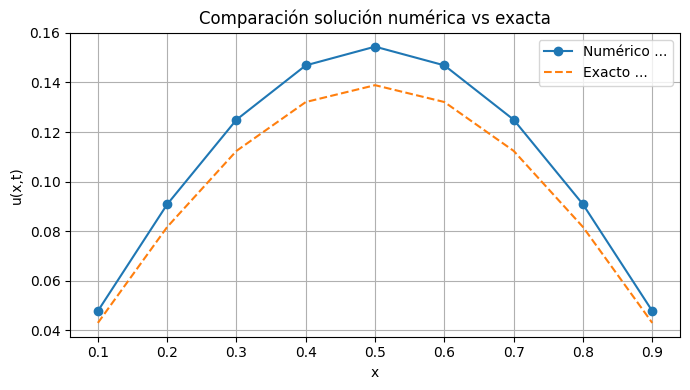

In [6]:
U=richardson_implicito(A, b0, nsteps)

def u_exacta(x,t):
    return np.exp(-np.pi**2*t) * np.sin(np.pi*x)

k_plot=nsteps
t_plot=ts[k_plot]

u_num=U[k_plot,:]
u_ex=u_exacta(xs,t_plot)
plt.figure(figsize=(7, 4))
plt.plot(xs, u_num, 'o-', label='Numérico ...')
plt.plot(xs, u_ex, '--', label='Exacto ...')
plt.xlabel('x'); plt.ylabel('u(x,t)')
plt.title('Comparación solución numérica vs exacta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#6.- Mapa de Colores
Lo que hace es:

• Construye una malla \((x,t)\) compatible con el arreglo \(U[k,i]\).

• Dibuja un mapa de colores de \(u(x,t)\): muestra cómo decae la solución en el tiempo.

Notas de sintaxis:

• np.meshgrid(xs, ts) devuelve dos matrices \(X\) y \(T_{\text{mesh}}\) con las coordenadas repetidas.

• plt.contourf genera contornos rellenos.

• cmap=cm.viridis elige el mapa de color “viridis”.


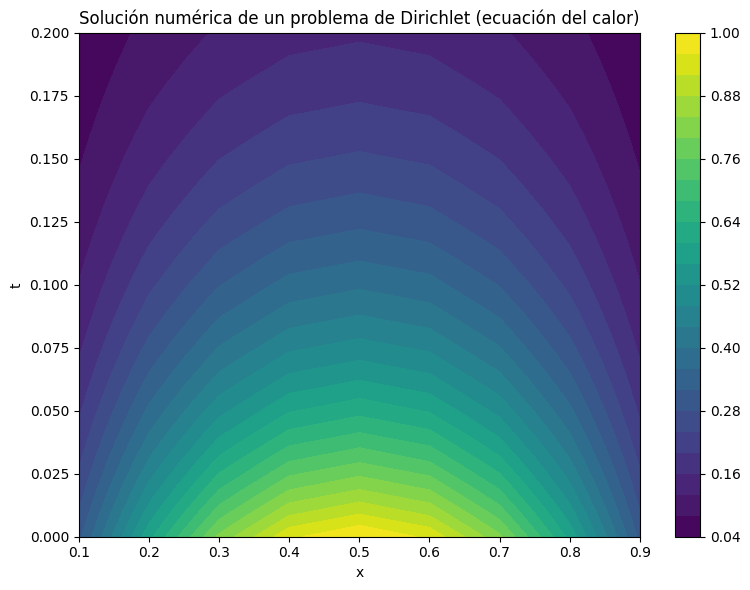

In [7]:
X,Tmesh=np.meshgrid(xs,ts)

plt.figure(figsize=(8,6))
contour = plt.contourf(X,Tmesh,U,levels=25,cmap=cm.viridis)
plt.colorbar(contour)
plt.title('Solución numérica de un problema de Dirichlet (ecuación del calor)')
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()
plt.show()

# 7.- Superficie 3D
Lo que hace es:

• Representa \(u(x,t)\) como superficie 3D:  
  eje horizontal \(x\), eje “fondo” \(t\), eje vertical \(u\).

Notas de sintaxis:

• fig.add_subplot(111, projection='3d') crea un eje 3D.

• plot_surface(X, Tmesh, U, ...) grafica la superficie.

• ax.set_* modifica las etiquetas del eje correspondiente.

• fig.colorbar(..., shrink=0.5, aspect=5) añade una barra de color ajustando tamaño.


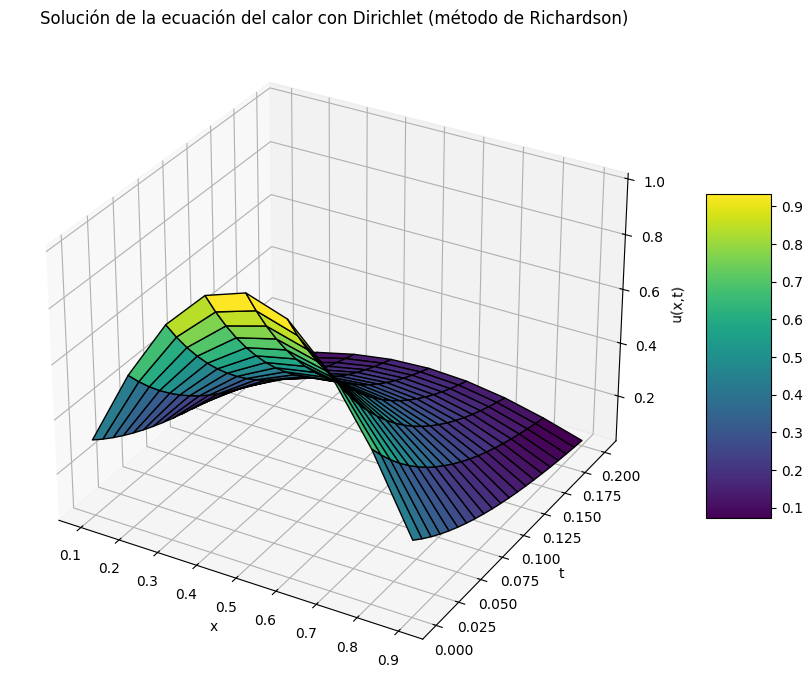

In [8]:
fig=plt.figure(figsize=(10, 7))
ax=fig.add_subplot(111,projection='3d')
surf=ax.plot_surface(X,Tmesh,U,cmap=cm.viridis,edgecolor='k')
ax.set_title('Solución de la ecuación del calor con Dirichlet (método de Richardson)')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
fig.colorbar(surf,shrink=0.5,aspect=5)
plt.tight_layout()
plt.show()